Please download the datasets from here: https://drive.google.com/open?id=1mNEblJS0622w5-2mB6yCyMbu7RbcfENL<br>
This should contain the following:
- __5_min_train__: training data as np array. Shape: (7500, 64, 64, 8)
- __5_min_xval__: validation data (currently unused) as np array. Shape: (1500, 64, 64, 8)
- __5_min_test__: test data (used as visual validation during training) as np array. Shape: (1000, 64, 64, 8)
- __5_min_norms__: list of floats containing the maximum pixel intensity value prior to normalization for each sequence. Shape: (10000,)
- __5_min_long_pred__: test data for sequence prediction as np array. We used it for testing after training. Shape: (1000, 64, 64, 20)
- __5_min_long_pred_norms__: list of floats containing the maximum pixel intensity value prior to normalization for each sequence for the 5_min_long_pred dataset. Shape: (1000,)
- __tgan_1/2/4-1_vx/vy_2000__: optical flow images between the last and second last frames of the input for the first 2000 sequences of the training dataset (__5_min_train__) as np array. The 1/2/4 means the length of the input sequence. We mostly used 2. Shape: (2000, 64, 64, 1)
- __germany__: Not needed. (GPS coordinates of Germany. Used for experimenting before.)

In the datasets the first axis is stands for the sample, the next two for the frame height and width and the last for the channels which is the time axis here.<br>
If data is missing or you cannot acces the drive, please write me an E-Mail: pkicsiny@gmail.com

In [1]:
import src
import keras.backend as K
import os
import numpy as np
import sys
from functools import partial
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
#trainings folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/ADL4CV_project/trainings')
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17821261366869550675
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13529996540830758713
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [2]:
class RandomWeightedAverage(keras.layers.Concatenate):
    """Takes a randomly-weighted average of two tensors. In geometric terms, this outputs a random point on the line
    between each pair of input points.
    Inheriting from _Merge is a little messy but it was the quickest solution I could think of.
    Improvements appreciated."""

    def _merge_function(self, inputs):
        weights = K.random_uniform((batch_size, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1]) if len(inputs) == 2 else \
               [(weights * inputs[0]) + ((1 - weights) * inputs[1]), (weights * inputs[2]) + ((1 - weights) * inputs[3])]

Some global params

In [23]:
past = 2
name = f"tgan_{past}-1"
iterations = 5000
batch_size = 16
GRADIENT_PENALTY_WEIGHT = 10
nb_batches = int(gan_train.shape[0] / batch_size)
#generator trainings in 1 iter
g = 2
#spatial disc trainings in 1 iter
s = 1
#temporal disc trainings in 1 iter
t = 1
#initialize random seed
RND = 777
np.random.seed(RND)
#set this to true if you want to use a pretrained model and load its weights from file
use_loaded = True

Load dataset.

In [4]:
train, xval, test = src.load_datasets(past_frames=past+1)

Training data: (7500, 64, 64, 4)
Validation data: (1500, 64, 64, 4)
Test data: (1000, 64, 64, 4)


Split data to inputs and ground truth images.

In [5]:
gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            train[:2000], xval, test, past_frames=past+1, augment=True)

Data augmentation.
Shape of training data:  (8000, 64, 64, 3) 
Shape of training truth:  (8000, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 3) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 3) 
Shape of test truth:  (1000, 64, 64, 1)


Calculate optical flows between frame t-1 and t.

In [ ]:
#optical flow of the augmented data of the first 2000 training images (8000 images)
#vx, vy = src.optical_flow(gan_train[:,:,:,-2:-1], gan_train[:,:,:,-1:], window_size=4, tau=1e-2, init=1) # (n,:,:,1)

Save optical flows

In [ ]:
#np.savez_compressed(f"{name}_vx_2000",vx) #2000 denotes that they re the flo2 of the first 2000 samples from the training dataset
#np.savez_compressed(f"{name}_vy_2000",vy)

If optical flows are saved, load them

In [6]:
vx = np.load(sys.path[0]+f"/{name}_vx_2000.npz")["arr_0"]
vy = np.load(sys.path[0]+f"/{name}_vy_2000.npz")["arr_0"]

Preprocess optical flows

In [7]:
normalized_optical_flow = src.normalize_flows(vx, vy)
flows = np.transpose([[ndimage.median_filter(image[..., ch], 4) for ch in range(2)] for image in normalized_optical_flow], (0, 2, 3, 1))

Make generator but don't compile.

In [32]:
generator = src.unet((64, 64, past), dropout=0, batchnorm=True, kernel_size=4, feature_mult=1)

Make discriminators and compile.

In [33]:
s_discriminator = src.spatial_discriminator(condition_shape=(64, 64, past), dropout = 0, batchnorm=True, wgan=True)
s_discriminator.compile(loss=src.wasserstein_loss,
                        optimizer=keras.optimizers.RMSprop(lr=0.00005))

In [34]:
t_discriminator = src.temporal_discriminator(dropout = 0, batchnorm=True, wgan=True)
t_discriminator.compile(loss=src.wasserstein_loss,
                        optimizer=keras.optimizers.RMSprop(lr=0.00005))

Inputs and outputs of the GAN.

In [35]:
frame_t = keras.layers.Input(shape=(64, 64, past), name='input_condition_')
adv = keras.layers.Input(shape=(64, 64, 1), name="advected_frame")

In [36]:
generated = generator(frame_t)
s_score_fake = s_discriminator([frame_t, generated])
t_score_fake = t_discriminator([adv, generated])

Freeze discriminator weights.

In [37]:
s_discriminator.trainable = False
t_discriminator.trainable = False

Compile combined model.

In [38]:
loss_weights=[0, 1, 1]

In [39]:
combined = keras.models.Model(inputs=[frame_t, adv], outputs=[generated, s_score_fake, t_score_fake], name="combined_model")

In [40]:
combined.compile(loss=[src.custom_loss(loss="l1"),
                       src.wasserstein_loss,
                       src.wasserstein_loss],
                 optimizer=keras.optimizers.RMSprop(lr=0.00005),
                 loss_weights=loss_weights)

***Using L1 loss.***


Make gradient penalty

In [41]:
for l in s_discriminator.layers:
    l.trainable = True
for l in t_discriminator.layers:
    l.trainable = True
for l in generator.layers:
    l.trainable = False

s_discriminator.trainable = True
t_discriminator.trainable = True
generator.trainable = False

Inputs and outputs

In [42]:
real_samples = keras.layers.Input(shape=(64, 64, 1), name="ground_truth")
adv_real = keras.layers.Input(shape=(64, 64, 1), name="real_advected")

frame_t = keras.layers.Input(shape=(64, 64, past), name="input_sequence")
adv = keras.layers.Input(shape=(64, 64, 1), name="fake_advected")

generated = generator(frame_t)

In [43]:
ds_output_generated = s_discriminator([frame_t, generated])
ds_output_real = s_discriminator([frame_t, real_samples])
s_averaged_samples = RandomWeightedAverage()([real_samples, generated])
ds_output_avg = s_discriminator([frame_t, s_averaged_samples])

dt_output_generated = t_discriminator([adv, generated])
dt_output_real = t_discriminator([adv_real, real_samples])
t_averaged_samples, t_averaged_advections = RandomWeightedAverage()([real_samples, generated, adv_real, adv])
dt_output_avg = t_discriminator([t_averaged_advections, t_averaged_samples])

Partial losses

In [44]:
s_partial_gp_loss = partial(src.gradient_penalty_loss,
                          averaged_samples=s_averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
s_partial_gp_loss.__name__ = 's_gradient_penalty' 

t_partial_gp_loss = partial(src.gradient_penalty_loss,
                          averaged_samples=t_averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
t_partial_gp_loss.__name__ = 't_gradient_penalty' 

Compile

In [45]:
Ds = keras.models.Model(inputs=[frame_t, real_samples],
                                   outputs=[ds_output_real,
                                            ds_output_generated,
                                            ds_output_avg])

Dt = keras.models.Model(inputs=[frame_t, real_samples, adv, adv_real],
                                   outputs=[dt_output_real,
                                            dt_output_generated,
                                            dt_output_avg])

In [47]:
Ds.compile(optimizer=keras.optimizers.RMSprop(lr=0.00005),
          loss=[src.wasserstein_loss, src.wasserstein_loss, s_partial_gp_loss])

Dt.compile(optimizer=keras.optimizers.RMSprop(lr=0.00005),
          loss=[src.wasserstein_loss, src.wasserstein_loss, t_partial_gp_loss])

Labels

In [48]:
positive_y = np.ones((batch_size, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((batch_size, 1), dtype=np.float32)

Log dict

In [49]:
log = {"g_loss":[],
       "ds_loss":[],
       "dt_loss":[],
       "ds_loss_real":[],
       "ds_loss_fake":[],
       "ds_loss_avg":[],
       'ds_loss_wgan':[],
       "dt_loss_real":[],
       "dt_loss_fake":[],
       "dt_loss_avg":[],
       'dt_loss_wgan':[]}


1001/0 [Ds loss real: -666.0885009765625 Ds loss fake: -579.8444213867188 Ds loss avg: 1.9834738969802856] 
1001/0 [Dt loss real: -326.2204284667969 Dt loss fake: -185.8221435546875 Dt loss avg: 21.403446197509766]
1001/1 [Ds loss real: -667.7123413085938 Ds loss fake: -579.8759765625 Ds loss avg: 2.2522683143615723] 
1001/1 [Dt loss real: -310.44903564453125 Dt loss fake: -186.05575561523438 Dt loss avg: 10.438220977783203]
1001/2 [Ds loss real: -669.1717529296875 Ds loss fake: -580.2530517578125 Ds loss avg: 4.8046875] 
1001/2 [Dt loss real: -320.4957275390625 Dt loss fake: -183.24534606933594 Dt loss avg: 12.204992294311523]
1001/3 [Ds loss real: -668.0418701171875 Ds loss fake: -580.1429443359375 Ds loss avg: 1.6758184432983398] 
1001/3 [Dt loss real: -323.9272766113281 Dt loss fake: -185.73191833496094 Dt loss avg: 11.005278587341309]
1001/4 [Ds loss real: -669.3251953125 Ds loss fake: -580.2119140625 Ds loss avg: 1.4314368963241577] 
1001/4 [Dt loss real: -303.47882080078125 Dt 

1004/5 [Ds loss real: -673.48291015625 Ds loss fake: -584.0496826171875 Ds loss avg: 0.7599968314170837] 
1004/5 [Dt loss real: -339.4511413574219 Dt loss fake: -184.8280029296875 Dt loss avg: 6.661928176879883]
1004/6 [Ds loss real: -673.496337890625 Ds loss fake: -584.15966796875 Ds loss avg: 0.4315178096294403] 
1004/6 [Dt loss real: -327.451171875 Dt loss fake: -185.0448760986328 Dt loss avg: 27.146926879882812]
1004/7 [Ds loss real: -672.30029296875 Ds loss fake: -584.31640625 Ds loss avg: 1.5276026725769043] 
1004/7 [Dt loss real: -327.10107421875 Dt loss fake: -180.07183837890625 Dt loss avg: 12.452390670776367]
1004/8 [Ds loss real: -674.4485473632812 Ds loss fake: -584.1671142578125 Ds loss avg: 0.747451901435852] 
1004/8 [Dt loss real: -331.75115966796875 Dt loss fake: -182.7621612548828 Dt loss avg: 6.418084144592285]
1004/9 [Ds loss real: -672.9417114257812 Ds loss fake: -584.377197265625 Ds loss avg: 0.6524321436882019] 
1004/9 [Dt loss real: -288.17791748046875 Dt loss fa

KeyboardInterrupt: 

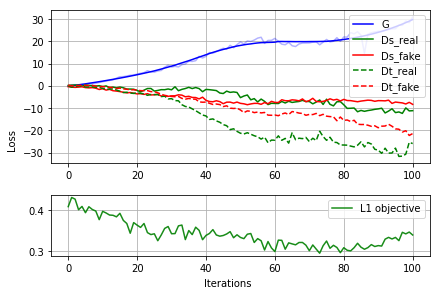

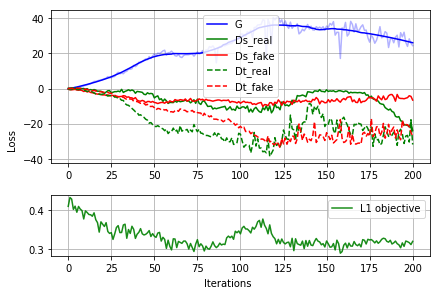

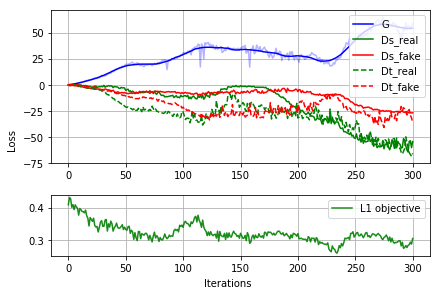

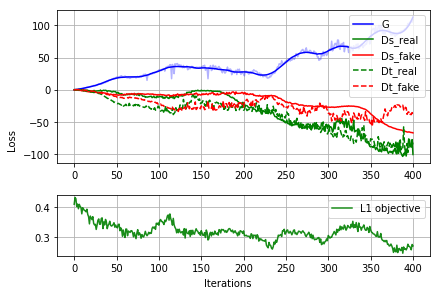

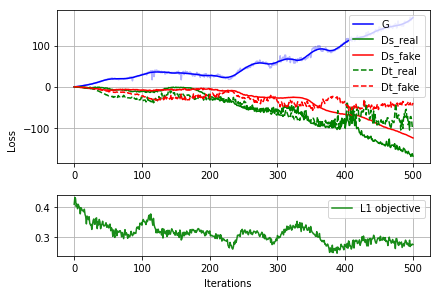

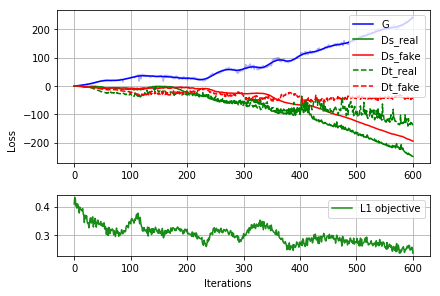

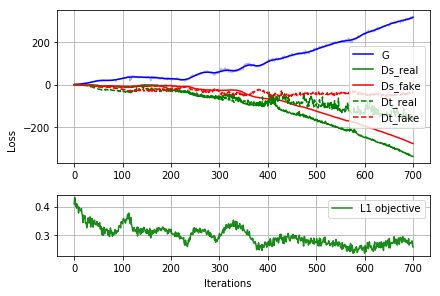

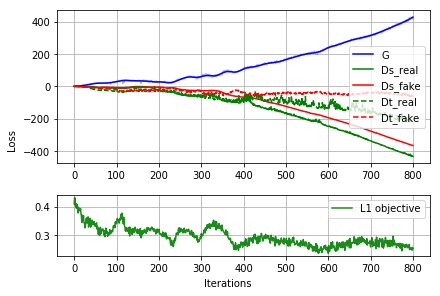

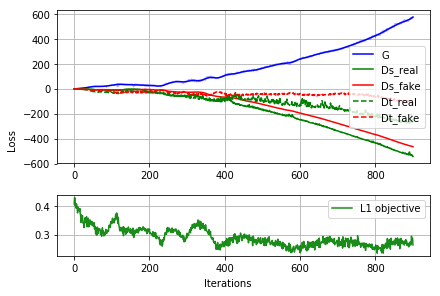

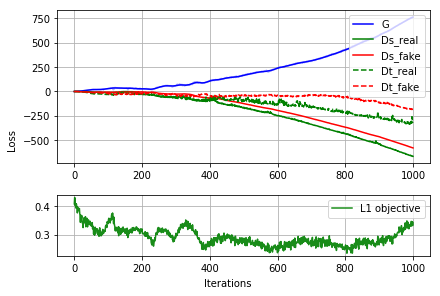

In [50]:
for it in range(iterations):
#batch
#idx = range(it%nb_batches * batch_size,(it%nb_batches + 1) * batch_size)
    if (it % 1000) < 25 or it % 500 == 0: # 25 times in 1000, every 500th
        d_iters = 10
    else:
        d_iters = 10
        
    s_discriminator.trainable = True
    for l in s_discriminator.layers: l.trainable = True
    t_discriminator.trainable = True
    for l in t_discriminator.layers: l.trainable = True
    generator.trainable = False
    for l in generator.layers: l.trainable = False
            
    for d_it in range(d_iters):
        idx = np.random.choice(gan_train.shape[0], batch_size, replace=False)
        real_imgs = gan_truth[idx]
        training_batch = gan_train[idx,:,:,1:]
        
        ds_loss = Ds.train_on_batch([training_batch, real_imgs], [negative_y, positive_y, dummy_y])
    
        idx = np.random.choice(gan_train.shape[0], batch_size, replace=False)
        real_imgs = gan_truth[idx]
        training_batch = gan_train[idx,:,:,1:]
        aux_batch = gan_train[idx,:,:,:-1]
            
        advected_aux_gen = generator.predict(aux_batch)
        advected_aux_truth = training_batch[:,:,:,-1:]
        for i in range(10):
            advected_aux_gen = np.array([src.advect(sample, order=2) for sample in np.concatenate((advected_aux_gen, -flows[idx]), axis=-1)])
            advected_aux_truth = np.array([src.advect(sample, order=2) for sample in np.concatenate((advected_aux_truth, -flows[idx]), axis=-1)])
        
        dt_loss = Dt.train_on_batch([training_batch,
                                     real_imgs,
                                     advected_aux_gen,
                                     advected_aux_truth], [negative_y, positive_y, dummy_y])
        
        print(f"{it}/{d_it} [Ds loss real: {ds_loss[1]} Ds loss fake: {ds_loss[2]} Ds loss avg: {ds_loss[3]}] \n"+
              f"{it}/{d_it} [Dt loss real: {dt_loss[1]} Dt loss fake: {dt_loss[2]} Dt loss avg: {dt_loss[3]}]")

#Generator
    s_discriminator.trainable = False
    for l in s_discriminator.layers: l.trainable = False
    t_discriminator.trainable = False
    for l in t_discriminator.layers: l.trainable = False
    generator.trainable = True
    for l in generator.layers: l.trainable = True
        
    for tg in range(g):
        idx = np.random.choice(gan_train.shape[0], batch_size, replace=False)
        real_imgs = gan_truth[idx]
        training_batch = gan_train[idx,:,:,1:]
        aux_batch = gan_train[idx,:,:,:-1]

        advected = generator.predict(aux_batch)
        for i in range(10):
            advected = np.array([src.advect(sample, order=2) for sample in np.concatenate((advected, -flows[idx]), axis=-1)])  
    
        g_loss = combined.train_on_batch([training_batch, advected], [real_imgs, negative_y, negative_y])
    
    log["g_loss"].append(g_loss)
    log["ds_loss"].append(ds_loss) 
    log["dt_loss"].append(dt_loss)
    log["ds_loss_real"].append(ds_loss[1])
    log["ds_loss_fake"].append(ds_loss[2])
    log["ds_loss_avg"].append(ds_loss[3])
    log['ds_loss_wgan'].append(-1 * ds_loss[1] + ds_loss[2])
    log["dt_loss_real"].append(dt_loss[1])
    log["dt_loss_fake"].append(dt_loss[2])
    log["dt_loss_avg"].append(dt_loss[3])
    log['dt_loss_wgan'].append(-1 * dt_loss[1] + dt_loss[2])
    
    
    print(f"\033[1m {it} [G loss: {g_loss}]\033[0m \n"+
          f" Ds: real loss: {ds_loss[1]}, fake loss: {ds_loss[2]}, avg loss: {ds_loss[3]} \n"+
          f" Dt: real loss: {dt_loss[1]}, fake loss: {dt_loss[2]}, avg loss: {dt_loss[3]}")
    if it%100 == 0 and it>0:
        src.sample_images(it, gan_test[...,1:], gan_test_truth, past, generator)
        src.plot_advections(advected_aux_gen, advected_aux_truth, it)
        src.plot_temporal_training_curves(log, it, name, wgan=True)
        src.update_output("")

src.sample_images(iterations, gan_test[...,1:], gan_test_truth, past, generator)
src.plot_temporal_training_curves(log, iterations, name, wgan=True)

In [1]:
plt.plot(log["dt_loss_real"],label="real")
plt.plot(log["dt_loss_fake"],label="fake")
plt.grid()
plt.legend()

NameError: name 'plt' is not defined

In [ ]:
src.plot_temporal_training_curves(log, iterations, name, wgan=True)

In [ ]:
total_g_loss = np.array(log["g_loss"])[:,0]
total_d_loss = np.array(log["d_loss"])[:,0]
smoothed_tgl = src.smooth(np.array(log["g_loss"])[:,0])
smoothed_tdl = src.smooth(np.array(log["d_loss"])[:,0])
objective_loss = np.array(log["g_loss"])[:,1]

# plot 'em
f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[5, 2]})
a0.plot(total_g_loss, alpha=0.3, c="b")
a0.plot(total_d_loss, alpha=0.3, c="orange")
a0.plot(smoothed_tgl, c="b", label="generator")
a0.grid()
a0.plot(smoothed_tdl, c="orange", label="discriminator")
a0.legend()
a1.plot(objective_loss, alpha=0.9, c="green", label="L1 objective")
a1.grid()
a1.legend()
f.text(0.5, 0, 'Iterations', ha='center', va='center')
f.text(0, 0.5, 'Loss', ha='center', va='center', rotation='vertical')

f.tight_layout()
f.savefig(name+'_curves.png')

## Save features

Save model history

In [ ]:
np.save(name+"_log",log)

Save model weights

In [ ]:
combined.save_weights(name+"_model.h5")

Load model and predict

In [ ]:
combined.load_weights(sys.path[1]+"/"+name+"/"+name+"_model.h5")

Predict future frames. Loads a 20 long sequence with 1000 sequence samples.

In [ ]:
sequence_test = src.load_datasets(prediction=True)

In [ ]:
sequence_test = src.augment_data(sequence_test[:100])

In [ ]:
sequence_test.shape

In [ ]:
generator = combined.layers[1]

In [ ]:
#test
predictions = {}
past_frames = sequence_test[...,0:past]
test_truth = sequence_test[...,past:past+1]
for t in range(5):
    future = generator.predict(past_frames, batch_size=64)
    predictions[f"{t}"] = future
    past_frames = np.concatenate((past_frames[:,:,:,1:], predictions[f"{t}"]), axis=-1)
    test_truth = sequence_test[...,past+1+t:past+2+t]

Save example predictions

In [ ]:
def save_examples(name, test, predictions_dict, past, samples=0):
    fig, axs = plt.subplots(len(samples)*2,past+len(predictions_dict.keys()), figsize=(32, 32))
    fig.subplots_adjust(wspace=0.3, hspace=0.0)
    for n in range(len(samples)):
        vmax = np.max(test[n,:,:,:past])
        vmin = 0
        print(test.shape)
        for i in range(past):
            im = axs[2*n,i].imshow(test[samples[n], :,:,i], vmax=vmax,vmin=vmin)
            axs[2*n,i].axis('off')
            axs[2*n,i].set_title(f"Past frame {i+1}")
            src.colorbar(im)
            im = axs[2*n+1,i].imshow(test[samples[n], :,:,i], vmax=vmax,vmin=vmin)
            axs[2*n+1,i].axis('off')
            axs[2*n+1,i].set_title(f"Past frame {i+1}")
            src.colorbar(im)
        for i in range(past,past+len(predictions_dict.keys())):
            im = axs[2*n,i].imshow(predictions_dict[f"{i-past}"][samples[n], :,:,0], vmax=vmax, vmin=vmin)
            axs[2*n,i].axis('off')
            axs[2*n,i].set_title(f"Predicted frame {i-past+1}")
            src.colorbar(im)
            im = axs[2*n+1,i].imshow(test[samples[n], :,:,i], vmax=vmax, vmin=vmin)
            axs[2*n+1,i].axis('off')
            axs[2*n+1,i].set_title(f"Reference frame {i-past+1}")
            src.colorbar(im)
    fig.savefig(f"Plots/{name}_sequence_prediction.png")
    plt.close()


In [ ]:
save_examples(name, sequence_test, predictions, past, samples=[33])

Renormalize intensity values

In [ ]:
norms = np.load(sys.path[0]+"/5min_norms_compressed.npz")["arr_1"]

In [ ]:
# *4 bc of augmentaion (it concats the frames so the 0th 1000th 2000th and 3000th are the same sample just rotated)
test_norms = list(norms[9000:])*4

In [ ]:
#renormalize test samples
renormalized_test = np.array([sample * np.array(test_norms)[i] for i, sample in enumerate(sequence_test)])
renormalized_predictions = np.transpose((np.array([[sample * np.array(test_norms)[i] for i, sample in enumerate(predictions[key])] for key in ['0', '1', '2', '3', "4"]])[:,:,:,:,0]), (1,2,3,0))

Calculate pixel intensities back to dBZ and from there to mm/h. <br>
Sources: <br>
- https://www.dwd.de/DE/leistungen/radolan/radolan_info/radolan_radvor_op_komposit_format_pdf.pdf?__blob=publicationFile&v=11 (page 10)
- <https://web.archive.org/web/20160113151652/http://www.desktopdoppler.com/help/nws-nexrad.htm#rainfall%20rates>

In [ ]:
#dBZ
dBZ_t = renormalized_test*0.5 - 32.5
dBZ_p = renormalized_predictions*0.5 - 32.5
#mm/h
I_t = (0.005*10**(0.1*dBZ_t))**(0.625)
I_p = (0.005*10**(0.1*dBZ_p))**(0.625)

In [ ]:
#thresholds: 2, 8, 42
thresholds = [0.5]
scores = {}
for t in range(5): # loop over the predictions
    for s in thresholds: # make a dict entry for each threshold score
        scores[f"pred_{t+1}"] = src.calculate_skill_scores(I_p[...,t:t+1],
                                                          I_t[...,past+t:past+1+t],
                                                          x=I_t[...,past-1:past],
                                                          threshold=s)

In [ ]:
scores.keys()

In [ ]:
np.save(name+"_scores",scores)

In [ ]:
scores["pred_1"]["corr_"]

In [ ]:
loaded_scores = np.load(sys.path[1]+"/"+name"/"+name+"_scores.npy").item()

In [ ]:
list(loaded_scores.keys())

In [ ]:
np.mean((pd.Series(scores["pred_1"]["corr_to_truth"]).dropna()))

In [ ]:
np.mean((pd.Series(scores["pred_1"]["corr_to_input"]).dropna()))